# Part 2: Perform the MCMC Density Fits

This notebook is Part 2 of the code for reproducing [Imig et al 2023](http://astronomy.nmsu.edu/jimig/Imig_MW_density.pdf). In this notebook, the effective selection function calcualted in Part 1 is applied to fit the density profile of each stellar population with an MCMC likelihood optimization.

**Note the config file** - mw_utils.py - which contains the density profiles, bin definitions, etc... ((i should split this up into smd_config, densprofiles, smd_plotfuncs or something!!))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import matplotlib.patheffects as PathEffects
import sys
import multiprocessing
import corner
import os
import sys

from mw_density import sample_selection, plotting_helpers, mcmc_functions
sample_selection.set_env_variables()


#for rawsel
#Use my sandbox version of APOGEE (DELETE THIS LATER)
sys.path.insert(1, '/Users/jimig/research/apogee/')
import apogee.select as apsel
import apogee.tools.read as apread
import dill as pickle
#import apogee.select as apsel
#import apogee.tools.read as apread
#import mwdust

#for coords
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.table import Column
from astropy.coordinates import Galactocentric



plt.rcParams.update({'font.size': 24})
import time

import warnings
#warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore','.*All-NaN.*',) #turn-off All-NaN warnings
warnings.filterwarnings('ignore','.*invalid value encountered in .*',) #turn-off NaN warnings

In [2]:
# Unique ID for saving files
unique_id = '7_25_24'

## 2A: Data Set Up

### Load in Files

In [3]:
# ===========================
# Define File Paths
# ===========================
# Effective Selection Function
effsel_name= 'data/selfuncs/effsel_allbins.npz'
# Raw Selection Function
rawsel = 'data/selfuncs/apogeeCombinedSF.dat'

# ===========================
# Load them in
# ===========================
effsel = np.load(effsel_name)['arr_0']

with open(rawsel, 'rb') as f:
    rawsel = pickle.load(f)

### Verify Effective Selection Function

In [4]:
#make sure efffsell is good for all binns
goodbins = 0
for i in range(len(effsel)):
    test = len(effsel[i][(effsel[i]!=0)&(np.isfinite(effsel[i]))])
    #print(test)
    if test >= 0.5*(len(effsel[i].flatten())): #more than 90% of effsel is good
        goodbins+=1
        
print(goodbins)

138


In [5]:
# times by Area
ndistmods, distances, distmods, minmax_distmods = sample_selection.distmod_bins()

if 'area' not in effsel_name:
    print('x area...')
    for i in range(len(effsel)):
        for loc_i, loc in enumerate(rawsel._locations):
            try:
                effsel[i][loc_i] = effsel[i][loc_i]*rawsel.area(loc)
            except:
                effsel[i][loc_i] = effsel[i][loc_i]*0

#add that D**2 x delD factor to efffsel
delD = distances[1]-distances[0]
for i,f in enumerate(effsel):
    effsel[i]=effsel[i]*distances*distances*delD#*ds

x area...
/Users/jimig/research/apogee/apogee/select/apogeeSelect.py:2637: UserWarning: Different designs for this field have different radii; returning the first of these...
  warnings.warn("Different designs for this field have different radii; returning the first of these...")



In [6]:
# Coordinates for Effective Seleciton Function
effsel_glons = np.array([rawsel.glonGlat(x)[0][0] for x in rawsel._locations])
effsel_glats = np.array([rawsel.glonGlat(x)[1][0] for x in rawsel._locations])
distbins = distances*1000 #kpc to pc

effsel_lons = []
effsel_lats = []
effsel_dist = []

for loc_i in range(len(rawsel._locations)):
    for dist_i in range(len(distbins)):
        effsel_lons.append(effsel_glons[loc_i])
        effsel_lats.append(effsel_glats[loc_i])
        effsel_dist.append(distbins[dist_i])
        
effsel_lons = np.array(effsel_lons)
effsel_lats = np.array(effsel_lats)
effsel_dist = np.array(effsel_dist)

effsel_coords = coord.SkyCoord(l=effsel_lons * u.degree, 
                               b=effsel_lats * u.degree, 
                               distance=effsel_dist * u.pc, frame='galactic')

effsel_coords = effsel_coords.transform_to(coord.Galactocentric)

effsel_xs = effsel_coords.x/1000/u.pc
effsel_ys = effsel_coords.y/1000/u.pc
effsel_zs = effsel_coords.z/1000/u.pc
effsel_rs = np.sqrt((effsel_xs**2.0)+(effsel_ys**2.0))


### Sample Definition

...

See Section X.X in the paper


In [7]:
age_bins, mh_bins = sample_selection.setup_maap_bins()
apogee_sample = fits.open('data/apogee_sample.fits')[1].data

logg_min_lim = np.min(apogee_sample['LOGG'])
logg_max_lim = np.max(apogee_sample['LOGG'])

metals = apogee_sample['M_H']
alphas = apogee_sample['ALPHA_M']
ages = apogee_sample['AGE']
data_rs = apogee_sample['GALACTIC_R']
data_zs = apogee_sample['GALACTIC_Z']

### Calculate Coordinates, other data


In [8]:
print(f"Total Number of stars in Sample: {len(metals)}")

Total Number of stars in Sample: 203197


### Count how many stars are in each stellar population bin

In [9]:
ncount_distmass_HIGH=np.zeros((len(age_bins['center']),len(mh_bins['center'])))
ncount_distmass_LOW=np.zeros((len(age_bins['center']),len(mh_bins['center'])))

tot = len(age_bins['center'])*len(mh_bins['center'])

low_alph_mask,high_alph_mask = sample_selection.get_alpha_masks(apogee_sample)

cnter=0
for i_a, age in enumerate(age_bins['center']):
    for i_m, mh in enumerate(mh_bins['center']):
        m = (apogee_sample['AGE_BIN_I']==i_a)&(apogee_sample['METAL_BIN_I']==i_m)        
        hm = m&high_alph_mask
        lm = m&low_alph_mask
        ncount_distmass_HIGH[i_a,i_m] = len(hm[hm])
        ncount_distmass_LOW[i_a,i_m] = len(lm[lm])
        
        cnter+=1
        #print('{}/{}'.format(cnter,tot))

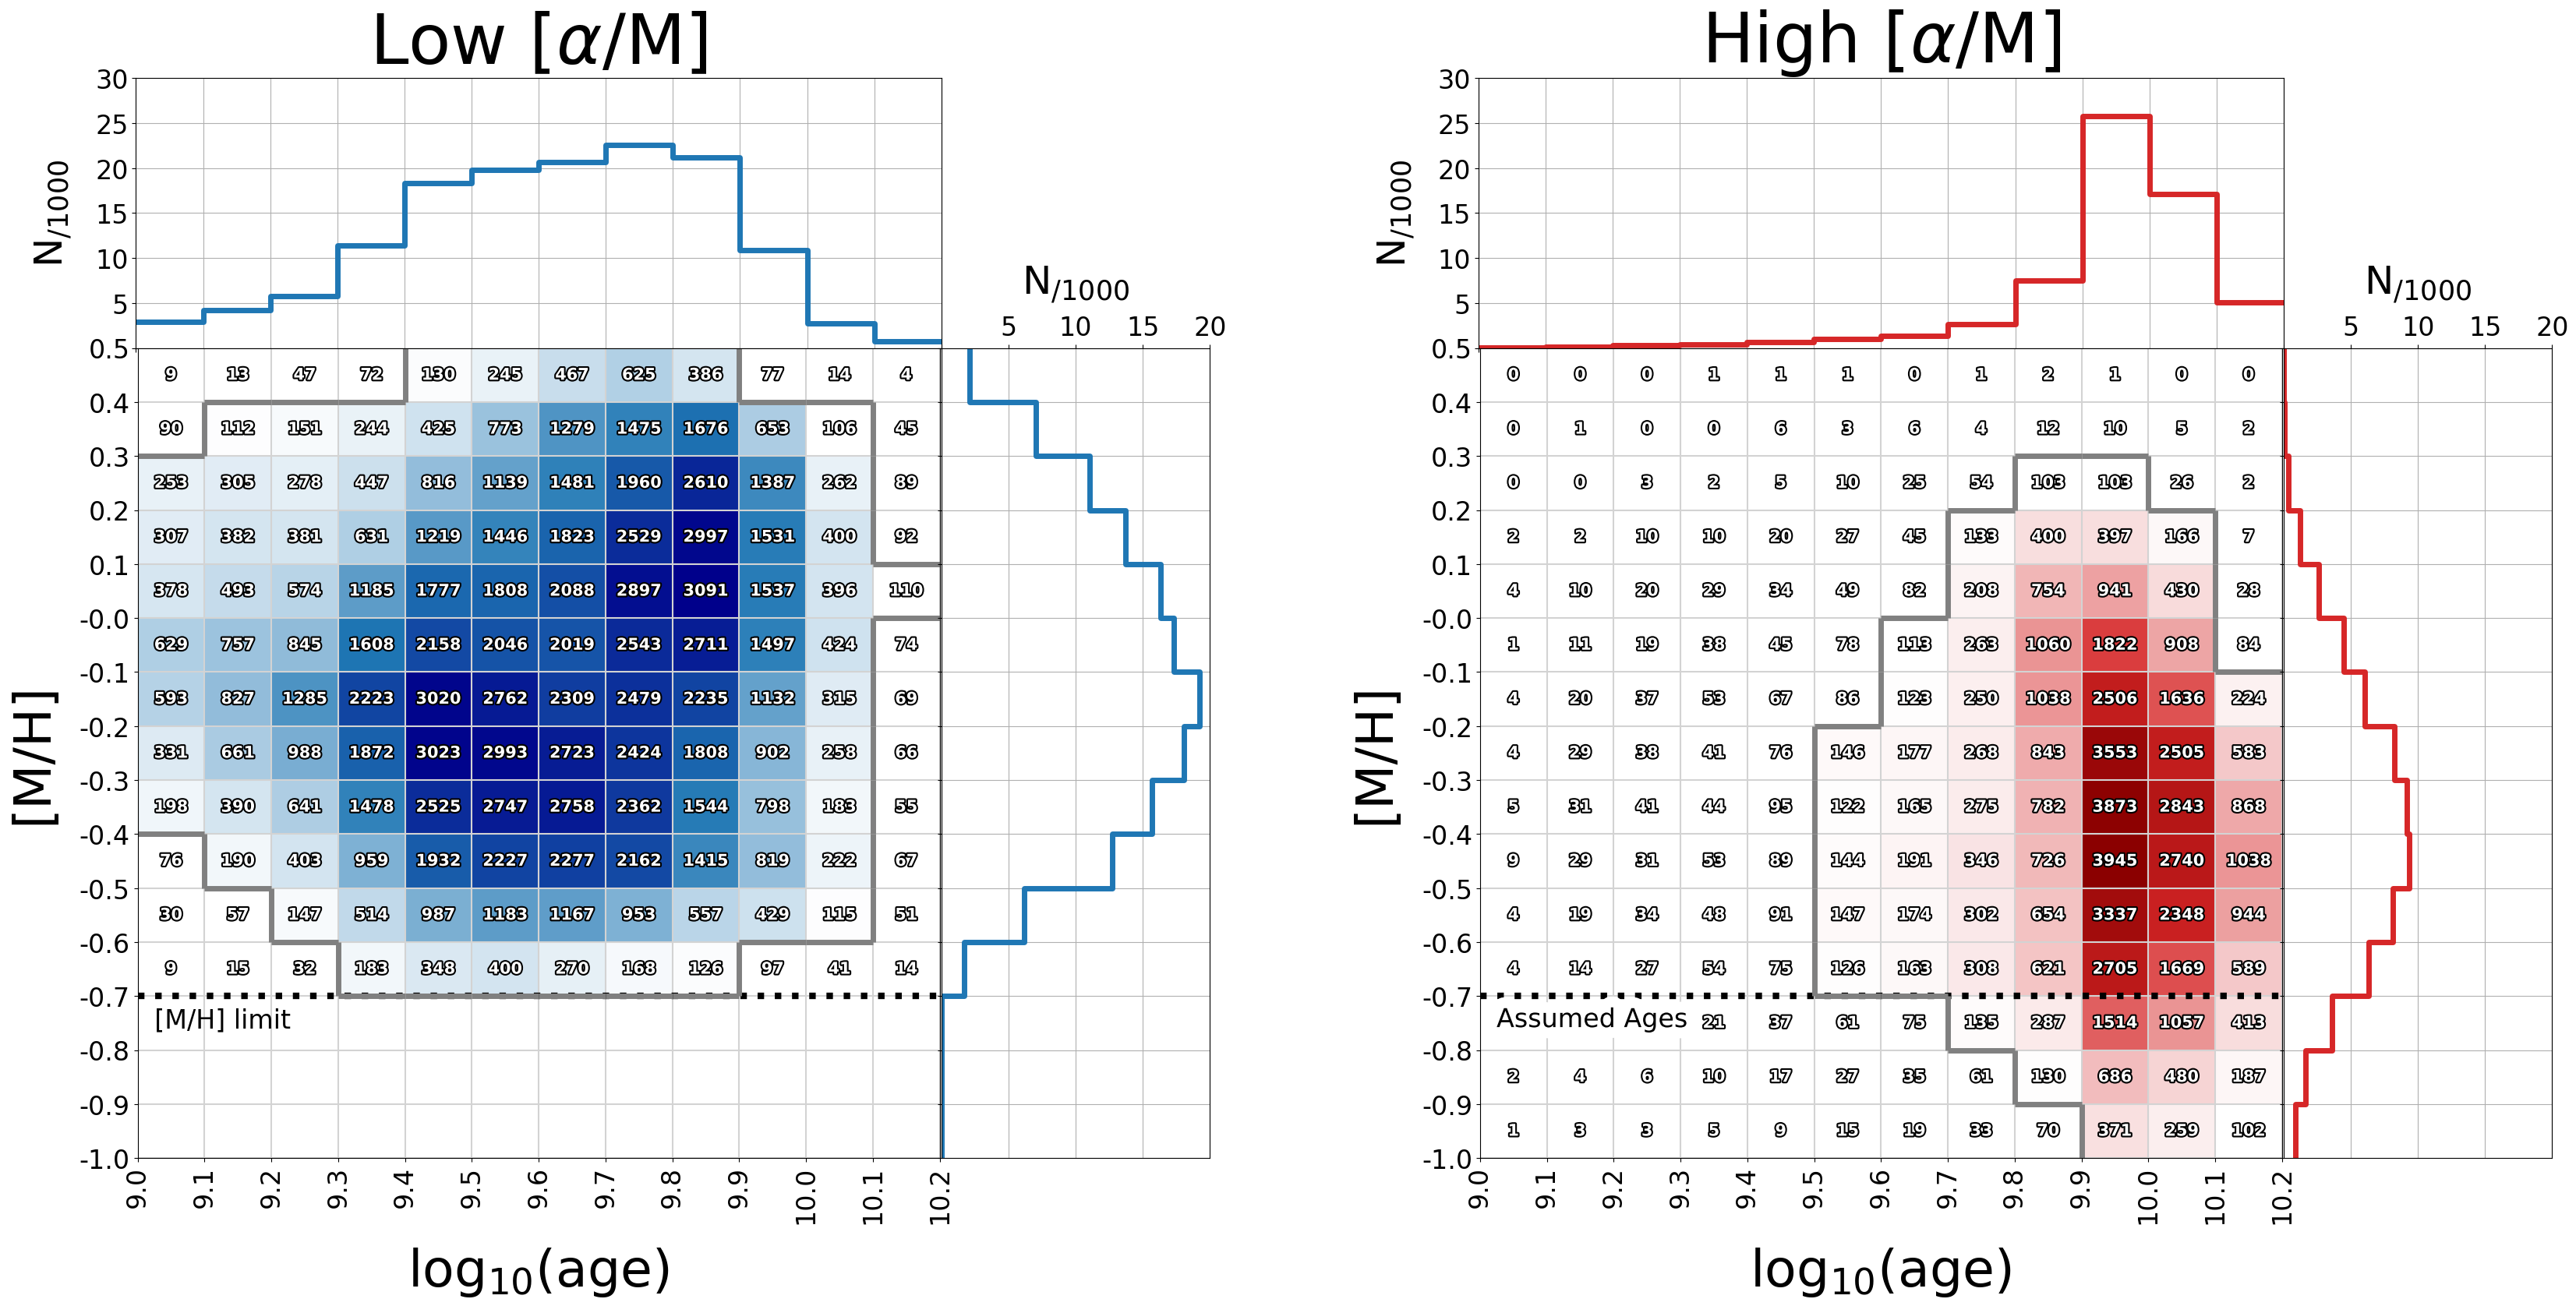

In [10]:
plotting_helpers.bin_count_plot_histo(ncount_distmass_LOW,ncount_distmass_HIGH)

## 2B: MCMC Set Up

Based on: https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial_Solution.html

### Define probability functions


## 2C: Perform the MCMC fits

This generally takes a few minutes for each bin.

In [11]:
#Set to FALSE if you want to preserve progress
overwrite_files = True

In [12]:
#High alpha bins
bin_counter = 0
N_bins = len(mh_bins['center'])*len(age_bins['center'])    

TESTBIN = 39
#repeat_bins = [5,25,27,50,74] #bins with effsel problem
repeat_bins = []


for i_m,mh in enumerate(mh_bins['center']):
    for i_a,age in enumerate(age_bins['center']):
        # Log basic data
        print('='*50)
        print(f"Bin {bin_counter+1}/{N_bins}")
        fname = f'results/mcmc_chains/bin{bin_counter}_{unique_id}_high.npz'
        # Check if file exists:
        if not os.path.exists(fname) or (overwrite_files==True):
            # Get effsel for this bin
            bin_effsel = effsel[bin_counter]
            effsel_mask = (bin_effsel.flatten()!=0)&(np.isfinite(bin_effsel.flatten()))
            bin_effsel_rs = effsel_rs[effsel_mask]
            bin_effsel_zs = effsel_zs[effsel_mask]
            bin_effsel = bin_effsel.flatten()[effsel_mask]
        
            effsel_dict = {'bin_effsel': bin_effsel,
                           'bin_effsel_rs': bin_effsel_rs,
                           'bin_effsel_zs': bin_effsel_zs}
            
            # Run MCMC
            mcmc_functions.perform_MAAP_density_fit(apogee_sample, effsel_dict,
                                                    i_m, i_a, 'HIGH', fname)
        else: # File aready exists.
            print(f"File {fname} already exists. Skipping bin. (Set overwrite_files=True to override)")
            
        bin_counter +=1


Bin 1/180
N=1 stars
[M/H] = -0.95, age = 1.12, alpha = HIGH
N_stars = 1 is less than minimum of 100. Skipping bin.
Bin 2/180
N=3 stars
[M/H] = -0.95, age = 1.41, alpha = HIGH
N_stars = 3 is less than minimum of 100. Skipping bin.
Bin 3/180
N=3 stars
[M/H] = -0.95, age = 1.78, alpha = HIGH
N_stars = 3 is less than minimum of 100. Skipping bin.
Bin 4/180
N=5 stars
[M/H] = -0.95, age = 2.24, alpha = HIGH
N_stars = 5 is less than minimum of 100. Skipping bin.
Bin 5/180
N=9 stars
[M/H] = -0.95, age = 2.82, alpha = HIGH
N_stars = 9 is less than minimum of 100. Skipping bin.
Bin 6/180
N=15 stars
[M/H] = -0.95, age = 3.55, alpha = HIGH
N_stars = 15 is less than minimum of 100. Skipping bin.
Bin 7/180
N=19 stars
[M/H] = -0.95, age = 4.47, alpha = HIGH
N_stars = 19 is less than minimum of 100. Skipping bin.
Bin 8/180
N=33 stars
[M/H] = -0.95, age = 5.62, alpha = HIGH
N_stars = 33 is less than minimum of 100. Skipping bin.
Bin 9/180
N=70 stars
[M/H] = -0.95, age = 7.08, alpha = HIGH
N_stars = 70 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:30<00:00,  1.75it/s]


[ 0.63819008  3.18325332  1.34886811 15.90406296  0.09985871 -2.642843  ]
Bin 11/180
N=259 stars
[M/H] = -0.95, age = 11.22, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:13<00:00,  1.49it/s]


[ 0.22087936  0.95163889  1.36296804  8.15416599  0.09805351 -2.41595382]
Bin 12/180
N=102 stars
[M/H] = -0.95, age = 14.13, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.59it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:52<00:00,  1.69it/s]


[ 0.46579112  1.22014036  1.45759107  8.81650037  0.09941756 -2.39413487]
Bin 13/180
N=2 stars
[M/H] = -0.85, age = 1.12, alpha = HIGH
N_stars = 2 is less than minimum of 100. Skipping bin.
Bin 14/180
N=4 stars
[M/H] = -0.85, age = 1.41, alpha = HIGH
N_stars = 4 is less than minimum of 100. Skipping bin.
Bin 15/180
N=6 stars
[M/H] = -0.85, age = 1.78, alpha = HIGH
N_stars = 6 is less than minimum of 100. Skipping bin.
Bin 16/180
N=10 stars
[M/H] = -0.85, age = 2.24, alpha = HIGH
N_stars = 10 is less than minimum of 100. Skipping bin.
Bin 17/180
N=17 stars
[M/H] = -0.85, age = 2.82, alpha = HIGH
N_stars = 17 is less than minimum of 100. Skipping bin.
Bin 18/180
N=27 stars
[M/H] = -0.85, age = 3.55, alpha = HIGH
N_stars = 27 is less than minimum of 100. Skipping bin.
Bin 19/180
N=35 stars
[M/H] = -0.85, age = 4.47, alpha = HIGH
N_stars = 35 is less than minimum of 100. Skipping bin.
Bin 20/180
N=61 stars
[M/H] = -0.85, age = 5.62, alpha = HIGH
N_stars = 61 is less than minimum of 100. Sk

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:47<00:00,  1.70it/s]


[ 0.76469538  4.51206857  1.16345225 12.14141648  0.09284403 -2.83617505]
Bin 22/180
N=686 stars
[M/H] = -0.85, age = 8.91, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:30<00:00,  1.75it/s]


[ 0.68817123  3.50328353  1.20096513 13.82970757  0.09980945 -2.71812261]
Bin 23/180
N=480 stars
[M/H] = -0.85, age = 11.22, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:48<00:00,  1.41it/s]


[ 0.40345253  1.17514854  1.17028542  8.9487561   0.09796681 -2.35557842]
Bin 24/180
N=187 stars
[M/H] = -0.85, age = 14.13, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.61it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:08<00:00,  1.82it/s]


[ 0.57360707  4.21878067  1.45569342 13.83847111  0.09957103 -2.42462009]
Bin 25/180
N=3 stars
[M/H] = -0.75, age = 1.12, alpha = HIGH
N_stars = 3 is less than minimum of 100. Skipping bin.
Bin 26/180
N=10 stars
[M/H] = -0.75, age = 1.41, alpha = HIGH
N_stars = 10 is less than minimum of 100. Skipping bin.
Bin 27/180
N=14 stars
[M/H] = -0.75, age = 1.78, alpha = HIGH
N_stars = 14 is less than minimum of 100. Skipping bin.
Bin 28/180
N=21 stars
[M/H] = -0.75, age = 2.24, alpha = HIGH
N_stars = 21 is less than minimum of 100. Skipping bin.
Bin 29/180
N=37 stars
[M/H] = -0.75, age = 2.82, alpha = HIGH
N_stars = 37 is less than minimum of 100. Skipping bin.
Bin 30/180
N=61 stars
[M/H] = -0.75, age = 3.55, alpha = HIGH
N_stars = 61 is less than minimum of 100. Skipping bin.
Bin 31/180
N=75 stars
[M/H] = -0.75, age = 4.47, alpha = HIGH
N_stars = 75 is less than minimum of 100. Skipping bin.
Bin 32/180
N=135 stars
[M/H] = -0.75, age = 5.62, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.49it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:44<00:00,  1.71it/s]


[ 0.73461863  2.33749795  1.10756544 14.16195925  0.09828537 -2.57607985]
Bin 33/180
N=287 stars
[M/H] = -0.75, age = 7.08, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.54it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:51<00:00,  1.88it/s]


[ 0.66261377  0.42364527  1.15536525 13.07355425  0.09904167 -2.59461731]
Bin 34/180
N=1514 stars
[M/H] = -0.75, age = 8.91, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:42<00:00,  1.56it/s]


[ 0.53300186  0.80828253  1.18212376  8.27514654  0.08977766 -2.51256437]
Bin 35/180
N=1057 stars
[M/H] = -0.75, age = 11.22, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:48<00:00,  1.89it/s]


[ 0.6556138   0.24334247  1.15572056 17.43770943  0.09939407 -2.62381911]
Bin 36/180
N=413 stars
[M/H] = -0.75, age = 14.13, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.58it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:47<00:00,  1.89it/s]


[ 0.70756312  4.70629519  1.15457898 12.5460093   0.09934989 -2.50107971]
Bin 37/180
N=4 stars
[M/H] = -0.65, age = 1.12, alpha = HIGH
N_stars = 4 is less than minimum of 100. Skipping bin.
Bin 38/180
N=14 stars
[M/H] = -0.65, age = 1.41, alpha = HIGH
N_stars = 14 is less than minimum of 100. Skipping bin.
Bin 39/180
N=27 stars
[M/H] = -0.65, age = 1.78, alpha = HIGH
N_stars = 27 is less than minimum of 100. Skipping bin.
Bin 40/180
N=54 stars
[M/H] = -0.65, age = 2.24, alpha = HIGH
N_stars = 54 is less than minimum of 100. Skipping bin.
Bin 41/180
N=75 stars
[M/H] = -0.65, age = 2.82, alpha = HIGH
N_stars = 75 is less than minimum of 100. Skipping bin.
Bin 42/180
N=126 stars
[M/H] = -0.65, age = 3.55, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.47it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:49<00:00,  1.54it/s]


[ 0.51865014  0.94763514  1.11060405  8.02661651  0.08809615 -2.41994547]
Bin 43/180
N=163 stars
[M/H] = -0.65, age = 4.47, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:38<00:00,  1.73it/s]


[ 0.61082014  4.41380828  1.09146747 13.66761945  0.09962187 -2.65262209]
Bin 44/180
N=308 stars
[M/H] = -0.65, age = 5.62, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:44<00:00,  1.71it/s]


[ 0.58116686  0.84759795  1.03280844  8.9271421   0.09191873 -2.43476847]
Bin 45/180
N=621 stars
[M/H] = -0.65, age = 7.08, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.54it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:54<00:00,  1.68it/s]


[ 0.57645293  0.85843043  1.07281745  8.56172792  0.0962941  -2.30516262]
Bin 46/180
N=2705 stars
[M/H] = -0.65, age = 8.91, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:08<00:00,  1.37it/s]


[ 0.46575098  0.87729594  1.07908453  7.95490202  0.08872112 -2.38939034]
Bin 47/180
N=1669 stars
[M/H] = -0.65, age = 11.22, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:45<00:00,  1.90it/s]


[ 0.86755976  0.69609016  1.11665785  4.84854396  0.09948207 -2.40490185]
Bin 48/180
N=589 stars
[M/H] = -0.65, age = 14.13, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:46<00:00,  1.71it/s]


[ 0.67473079  3.65884872  1.1490338  11.9773103   0.09923274 -2.54301411]
Bin 49/180
N=4 stars
[M/H] = -0.55, age = 1.12, alpha = HIGH
N_stars = 4 is less than minimum of 100. Skipping bin.
Bin 50/180
N=19 stars
[M/H] = -0.55, age = 1.41, alpha = HIGH
N_stars = 19 is less than minimum of 100. Skipping bin.
Bin 51/180
N=34 stars
[M/H] = -0.55, age = 1.78, alpha = HIGH
N_stars = 34 is less than minimum of 100. Skipping bin.
Bin 52/180
N=48 stars
[M/H] = -0.55, age = 2.24, alpha = HIGH
N_stars = 48 is less than minimum of 100. Skipping bin.
Bin 53/180
N=91 stars
[M/H] = -0.55, age = 2.82, alpha = HIGH
N_stars = 91 is less than minimum of 100. Skipping bin.
Bin 54/180
N=147 stars
[M/H] = -0.55, age = 3.55, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.41it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:15<00:00,  1.62it/s]


[ 0.47789494  0.8521699   0.94051667  7.36622555  0.09474848 -2.4771152 ]
Bin 55/180
N=174 stars
[M/H] = -0.55, age = 4.47, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:46<00:00,  1.71it/s]


[ 0.5673541   1.01227747  1.04570281  9.54234861  0.09550862 -2.34020126]
Bin 56/180
N=302 stars
[M/H] = -0.55, age = 5.62, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:16<00:00,  1.62it/s]


[ 0.56728377  0.87160009  0.9577468   8.07758409  0.09400122 -2.50144488]
Bin 57/180
N=654 stars
[M/H] = -0.55, age = 7.08, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:08<00:00,  1.50it/s]


[ 0.49927937  0.85395581  0.92772443  7.90105984  0.08187979 -2.42376521]
Bin 58/180
N=3337 stars
[M/H] = -0.55, age = 8.91, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.47it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:20<00:00,  1.35it/s]


[ 0.40693646  0.93407253  0.9656462   7.88394826  0.07933777 -2.30501747]
Bin 59/180
N=2348 stars
[M/H] = -0.55, age = 11.22, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:06<00:00,  1.65it/s]


[ 0.73411441  3.80475475  1.0512125  14.08492668  0.09030737 -2.62682426]
Bin 60/180
N=944 stars
[M/H] = -0.55, age = 14.13, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:57<00:00,  1.67it/s]


[ 0.64578931  1.07316986  1.06171328  9.78455584  0.09574162 -2.51745777]
Bin 61/180
N=9 stars
[M/H] = -0.45, age = 1.12, alpha = HIGH
N_stars = 9 is less than minimum of 100. Skipping bin.
Bin 62/180
N=29 stars
[M/H] = -0.45, age = 1.41, alpha = HIGH
N_stars = 29 is less than minimum of 100. Skipping bin.
Bin 63/180
N=31 stars
[M/H] = -0.45, age = 1.78, alpha = HIGH
N_stars = 31 is less than minimum of 100. Skipping bin.
Bin 64/180
N=53 stars
[M/H] = -0.45, age = 2.24, alpha = HIGH
N_stars = 53 is less than minimum of 100. Skipping bin.
Bin 65/180
N=89 stars
[M/H] = -0.45, age = 2.82, alpha = HIGH
N_stars = 89 is less than minimum of 100. Skipping bin.
Bin 66/180
N=144 stars
[M/H] = -0.45, age = 3.55, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.39it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:32<00:00,  1.58it/s]


[ 0.61807812  1.08026322  0.73546878  9.22365651  0.06257814 -2.27104323]
Bin 67/180
N=191 stars
[M/H] = -0.45, age = 4.47, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.43it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:21<00:00,  1.47it/s]


[ 0.43546145  0.86620276  0.83380879  8.03384824  0.06178071 -2.23196138]
Bin 68/180
N=346 stars
[M/H] = -0.45, age = 5.62, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:17<00:00,  1.48it/s]


[ 0.48788096  0.8814865   0.88462505  7.87987142  0.07539022 -2.3507055 ]
Bin 69/180
N=726 stars
[M/H] = -0.45, age = 7.08, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.41it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:29<00:00,  1.33it/s]


[ 0.40376638  0.88049057  0.76371046  7.84683452  0.05260808 -2.43834223]
Bin 70/180
N=3945 stars
[M/H] = -0.45, age = 8.91, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.49it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:06<00:00,  1.27it/s]


[ 0.38485048  0.97670284  0.85913323  7.80889397  0.07063123 -2.1399636 ]
Bin 71/180
N=2740 stars
[M/H] = -0.45, age = 11.22, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:12<00:00,  1.63it/s]


[ 0.74193587  1.92594345  0.89104902 13.84163835  0.0790024  -2.68401601]
Bin 72/180
N=1038 stars
[M/H] = -0.45, age = 14.13, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.59it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:11<00:00,  1.81it/s]


[ 0.56265875  0.8419743   0.91573146  7.55369733  0.08266441 -2.33115996]
Bin 73/180
N=5 stars
[M/H] = -0.35, age = 1.12, alpha = HIGH
N_stars = 5 is less than minimum of 100. Skipping bin.
Bin 74/180
N=31 stars
[M/H] = -0.35, age = 1.41, alpha = HIGH
N_stars = 31 is less than minimum of 100. Skipping bin.
Bin 75/180
N=41 stars
[M/H] = -0.35, age = 1.78, alpha = HIGH
N_stars = 41 is less than minimum of 100. Skipping bin.
Bin 76/180
N=44 stars
[M/H] = -0.35, age = 2.24, alpha = HIGH
N_stars = 44 is less than minimum of 100. Skipping bin.
Bin 77/180
N=95 stars
[M/H] = -0.35, age = 2.82, alpha = HIGH
N_stars = 95 is less than minimum of 100. Skipping bin.
Bin 78/180
N=122 stars
[M/H] = -0.35, age = 3.55, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:34<00:00,  1.44it/s]


[ 0.64988325  2.16252489  0.74484104  9.94592684  0.07011971 -2.3882327 ]
Bin 79/180
N=165 stars
[M/H] = -0.35, age = 4.47, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:32<00:00,  1.33it/s]


[ 0.44110436  1.08610563  0.68356321  8.7165931   0.047447   -2.25757282]
Bin 80/180
N=275 stars
[M/H] = -0.35, age = 5.62, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:58<00:00,  1.39it/s]


[ 0.40556568  0.86548945  0.70473834  7.258146    0.06084113 -2.31305438]
Bin 81/180
N=782 stars
[M/H] = -0.35, age = 7.08, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:35<00:00,  1.44it/s]


[ 0.49264449  0.88979563  0.67549594  8.190922    0.0496733  -2.27425358]
Bin 82/180
N=3873 stars
[M/H] = -0.35, age = 8.91, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:48<00:00,  1.30it/s]


[ 0.42806652  1.02414691  0.71781344  7.73689444  0.05949099 -2.26949812]
Bin 83/180
N=2843 stars
[M/H] = -0.35, age = 11.22, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:43<00:00,  1.71it/s]


[ 0.74761013  0.80870532  0.7554264   7.92272472  0.06650095 -2.07513318]
Bin 84/180
N=868 stars
[M/H] = -0.35, age = 14.13, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.56it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:41<00:00,  1.42it/s]


[ 0.473618    0.91176131  0.78117968  7.43350437  0.06352462 -2.36853543]
Bin 85/180
N=4 stars
[M/H] = -0.25, age = 1.12, alpha = HIGH
N_stars = 4 is less than minimum of 100. Skipping bin.
Bin 86/180
N=29 stars
[M/H] = -0.25, age = 1.41, alpha = HIGH
N_stars = 29 is less than minimum of 100. Skipping bin.
Bin 87/180
N=38 stars
[M/H] = -0.25, age = 1.78, alpha = HIGH
N_stars = 38 is less than minimum of 100. Skipping bin.
Bin 88/180
N=41 stars
[M/H] = -0.25, age = 2.24, alpha = HIGH
N_stars = 41 is less than minimum of 100. Skipping bin.
Bin 89/180
N=76 stars
[M/H] = -0.25, age = 2.82, alpha = HIGH
N_stars = 76 is less than minimum of 100. Skipping bin.
Bin 90/180
N=146 stars
[M/H] = -0.25, age = 3.55, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:41<00:00,  1.56it/s]


[ 0.49783367  0.92333722  0.57248246  7.22819731  0.04896621 -2.12432236]
Bin 91/180
N=177 stars
[M/H] = -0.25, age = 4.47, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:19<00:00,  1.35it/s]


[ 0.48574813  1.00676713  0.60870695  7.89567089  0.0434356  -2.33142239]
Bin 92/180
N=268 stars
[M/H] = -0.25, age = 5.62, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:19<00:00,  1.47it/s]


[ 0.6067306   4.73391222  0.64264206 11.64248825  0.05151052 -2.42362033]
Bin 93/180
N=843 stars
[M/H] = -0.25, age = 7.08, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:36<00:00,  1.32it/s]


[ 0.5602985   0.95226579  0.58265266  7.88542743  0.04978767 -2.32552074]
Bin 94/180
N=3553 stars
[M/H] = -0.25, age = 8.91, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.43it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:24<00:00,  1.24it/s]


[ 0.48432541  0.99334398  0.59628416  7.75500942  0.04855958 -2.2098475 ]
Bin 95/180
N=2505 stars
[M/H] = -0.25, age = 11.22, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:04<00:00,  1.38it/s]


[ 0.64725656  0.97006161  0.58375663  7.95811944  0.04244482 -2.31805766]
Bin 96/180
N=583 stars
[M/H] = -0.25, age = 14.13, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:10<00:00,  1.49it/s]


[ 0.6016277   0.91473167  0.69435365  7.7797617   0.06867708 -2.29687522]
Bin 97/180
N=4 stars
[M/H] = -0.15, age = 1.12, alpha = HIGH
N_stars = 4 is less than minimum of 100. Skipping bin.
Bin 98/180
N=20 stars
[M/H] = -0.15, age = 1.41, alpha = HIGH
N_stars = 20 is less than minimum of 100. Skipping bin.
Bin 99/180
N=37 stars
[M/H] = -0.15, age = 1.78, alpha = HIGH
N_stars = 37 is less than minimum of 100. Skipping bin.
Bin 100/180
N=53 stars
[M/H] = -0.15, age = 2.24, alpha = HIGH
N_stars = 53 is less than minimum of 100. Skipping bin.
Bin 101/180
N=67 stars
[M/H] = -0.15, age = 2.82, alpha = HIGH
N_stars = 67 is less than minimum of 100. Skipping bin.
Bin 102/180
N=86 stars
[M/H] = -0.15, age = 3.55, alpha = HIGH
N_stars = 86 is less than minimum of 100. Skipping bin.
Bin 103/180
N=123 stars
[M/H] = -0.15, age = 4.47, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.45it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:38<00:00,  1.57it/s]


[ 0.60133566  1.06257889  0.44138087  8.0250112   0.03453561 -2.31598396]
Bin 104/180
N=250 stars
[M/H] = -0.15, age = 5.62, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:47<00:00,  1.54it/s]


[ 0.60313809  1.03988136  0.49675217  8.51126976  0.04016481 -2.29285649]
Bin 105/180
N=1038 stars
[M/H] = -0.15, age = 7.08, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.47it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:40<00:00,  1.31it/s]


[ 0.59444339  0.97292264  0.49453904  7.90835115  0.03912431 -2.29814068]
Bin 106/180
N=2506 stars
[M/H] = -0.15, age = 8.91, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:52<00:00,  1.40it/s]


[ 0.47012156  1.10313709  0.50527905  7.91865271  0.03716006 -2.2534862 ]
Bin 107/180
N=1636 stars
[M/H] = -0.15, age = 11.22, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:42<00:00,  1.31it/s]


[ 0.56724453  1.01952722  0.52449987  8.07043941  0.03934287 -2.17386639]
Bin 108/180
N=224 stars
[M/H] = -0.15, age = 14.13, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.62it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:53<00:00,  1.68it/s]


[ 0.60276714  0.97670652  0.59778738  7.88592125  0.05396376 -2.18122565]
Bin 109/180
N=1 stars
[M/H] = -0.05, age = 1.12, alpha = HIGH
N_stars = 1 is less than minimum of 100. Skipping bin.
Bin 110/180
N=11 stars
[M/H] = -0.05, age = 1.41, alpha = HIGH
N_stars = 11 is less than minimum of 100. Skipping bin.
Bin 111/180
N=19 stars
[M/H] = -0.05, age = 1.78, alpha = HIGH
N_stars = 19 is less than minimum of 100. Skipping bin.
Bin 112/180
N=38 stars
[M/H] = -0.05, age = 2.24, alpha = HIGH
N_stars = 38 is less than minimum of 100. Skipping bin.
Bin 113/180
N=45 stars
[M/H] = -0.05, age = 2.82, alpha = HIGH
N_stars = 45 is less than minimum of 100. Skipping bin.
Bin 114/180
N=78 stars
[M/H] = -0.05, age = 3.55, alpha = HIGH
N_stars = 78 is less than minimum of 100. Skipping bin.
Bin 115/180
N=113 stars
[M/H] = -0.05, age = 4.47, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:31<00:00,  1.58it/s]


[ 0.63480154  0.88242498  0.48786611  7.50000257  0.03703932 -2.33955597]
Bin 116/180
N=263 stars
[M/H] = -0.05, age = 5.62, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.41it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:08<00:00,  1.64it/s]


[ 0.73295122  1.02840014  0.36670757  8.63895904  0.02412811 -2.0948659 ]
Bin 117/180
N=1060 stars
[M/H] = -0.05, age = 7.08, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:23<00:00,  1.34it/s]


[ 0.62147943  0.89835874  0.41532563  7.41116209  0.02719536 -2.36737436]
Bin 118/180
N=1822 stars
[M/H] = -0.05, age = 8.91, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:19<00:00,  1.25it/s]


[ 0.37242617  1.13750958  0.43441483  7.9063045   0.02741248 -2.01336477]
Bin 119/180
N=908 stars
[M/H] = -0.05, age = 11.22, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:44<00:00,  1.42it/s]


[ 0.43821832  1.10189224  0.48542996  7.78432738  0.03785635 -2.14644062]
Bin 120/180
N=84 stars
[M/H] = -0.05, age = 14.13, alpha = HIGH
N_stars = 84 is less than minimum of 100. Skipping bin.
Bin 121/180
N=4 stars
[M/H] = 0.05, age = 1.12, alpha = HIGH
N_stars = 4 is less than minimum of 100. Skipping bin.
Bin 122/180
N=10 stars
[M/H] = 0.05, age = 1.41, alpha = HIGH
N_stars = 10 is less than minimum of 100. Skipping bin.
Bin 123/180
N=20 stars
[M/H] = 0.05, age = 1.78, alpha = HIGH
N_stars = 20 is less than minimum of 100. Skipping bin.
Bin 124/180
N=29 stars
[M/H] = 0.05, age = 2.24, alpha = HIGH
N_stars = 29 is less than minimum of 100. Skipping bin.
Bin 125/180
N=34 stars
[M/H] = 0.05, age = 2.82, alpha = HIGH
N_stars = 34 is less than minimum of 100. Skipping bin.
Bin 126/180
N=49 stars
[M/H] = 0.05, age = 3.55, alpha = HIGH
N_stars = 49 is less than minimum of 100. Skipping bin.
Bin 127/180
N=82 stars
[M/H] = 0.05, age = 4.47, alpha = HIGH
N_stars = 82 is less than minimum of 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:11<00:00,  1.64it/s]


[ 0.79741272  1.08459769  0.39329572 10.16365558  0.029018   -2.16408287]
Bin 129/180
N=754 stars
[M/H] = 0.05, age = 7.08, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:59<00:00,  1.52it/s]


[ 0.59397719  1.07083427  0.37543232  7.81630306  0.01970631 -2.04916762]
Bin 130/180
N=941 stars
[M/H] = 0.05, age = 8.91, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.56it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:58<00:00,  1.28it/s]


[ 0.37091558  1.22922042  0.3943428   8.06256876  0.02545956 -2.1299993 ]
Bin 131/180
N=430 stars
[M/H] = 0.05, age = 11.22, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:37<00:00,  1.32it/s]


[ 0.34489479  1.02253294  0.41355977  6.88784041  0.03271127 -2.10766974]
Bin 132/180
N=28 stars
[M/H] = 0.05, age = 14.13, alpha = HIGH
N_stars = 28 is less than minimum of 100. Skipping bin.
Bin 133/180
N=2 stars
[M/H] = 0.15, age = 1.12, alpha = HIGH
N_stars = 2 is less than minimum of 100. Skipping bin.
Bin 134/180
N=2 stars
[M/H] = 0.15, age = 1.41, alpha = HIGH
N_stars = 2 is less than minimum of 100. Skipping bin.
Bin 135/180
N=10 stars
[M/H] = 0.15, age = 1.78, alpha = HIGH
N_stars = 10 is less than minimum of 100. Skipping bin.
Bin 136/180
N=10 stars
[M/H] = 0.15, age = 2.24, alpha = HIGH
N_stars = 10 is less than minimum of 100. Skipping bin.
Bin 137/180
N=20 stars
[M/H] = 0.15, age = 2.82, alpha = HIGH
N_stars = 20 is less than minimum of 100. Skipping bin.
Bin 138/180
N=27 stars
[M/H] = 0.15, age = 3.55, alpha = HIGH
N_stars = 27 is less than minimum of 100. Skipping bin.
Bin 139/180
N=45 stars
[M/H] = 0.15, age = 4.47, alpha = HIGH
N_stars = 45 is less than minimum of 100.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:33<00:00,  1.33it/s]


[ 0.5597638   1.27885328  0.37119584  8.34981441  0.02251968 -2.08330553]
Bin 141/180
N=400 stars
[M/H] = 0.15, age = 7.08, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:10<00:00,  1.37it/s]


[ 0.52211477  1.23214697  0.34972907  8.13450901  0.01868335 -2.19204365]
Bin 142/180
N=397 stars
[M/H] = 0.15, age = 8.91, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.58it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:54<00:00,  1.40it/s]


[ 0.28986886  1.23666966  0.39981043  7.77800146  0.02671859 -2.05428767]
Bin 143/180
N=166 stars
[M/H] = 0.15, age = 11.22, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.47it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:03<00:00,  1.38it/s]


[ 0.25792374  1.22752499  0.35134558  7.87738917  0.00992408 -2.06344687]
Bin 144/180
N=7 stars
[M/H] = 0.15, age = 14.13, alpha = HIGH
N_stars = 7 is less than minimum of 100. Skipping bin.
Bin 145/180
N=0 stars
[M/H] = 0.25, age = 1.12, alpha = HIGH
N_stars = 0 is less than minimum of 100. Skipping bin.
Bin 146/180
N=0 stars
[M/H] = 0.25, age = 1.41, alpha = HIGH
N_stars = 0 is less than minimum of 100. Skipping bin.
Bin 147/180
N=3 stars
[M/H] = 0.25, age = 1.78, alpha = HIGH
N_stars = 3 is less than minimum of 100. Skipping bin.
Bin 148/180
N=2 stars
[M/H] = 0.25, age = 2.24, alpha = HIGH
N_stars = 2 is less than minimum of 100. Skipping bin.
Bin 149/180
N=5 stars
[M/H] = 0.25, age = 2.82, alpha = HIGH
N_stars = 5 is less than minimum of 100. Skipping bin.
Bin 150/180
N=10 stars
[M/H] = 0.25, age = 3.55, alpha = HIGH
N_stars = 10 is less than minimum of 100. Skipping bin.
Bin 151/180
N=25 stars
[M/H] = 0.25, age = 4.47, alpha = HIGH
N_stars = 25 is less than minimum of 100. Skippin

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.56it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:05<00:00,  1.50it/s]


[ 0.61551368  3.33082869  0.35405977  9.39648914  0.02516585 -2.04558859]
Bin 154/180
N=103 stars
[M/H] = 0.25, age = 8.91, alpha = HIGH
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.71it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:02<00:00,  1.66it/s]


[ 0.19968953  1.25162165  0.36651255  6.85372107  0.04140564 -2.15127509]
Bin 155/180
N=26 stars
[M/H] = 0.25, age = 11.22, alpha = HIGH
N_stars = 26 is less than minimum of 100. Skipping bin.
Bin 156/180
N=2 stars
[M/H] = 0.25, age = 14.13, alpha = HIGH
N_stars = 2 is less than minimum of 100. Skipping bin.
Bin 157/180
N=0 stars
[M/H] = 0.35, age = 1.12, alpha = HIGH
N_stars = 0 is less than minimum of 100. Skipping bin.
Bin 158/180
N=1 stars
[M/H] = 0.35, age = 1.41, alpha = HIGH
N_stars = 1 is less than minimum of 100. Skipping bin.
Bin 159/180
N=0 stars
[M/H] = 0.35, age = 1.78, alpha = HIGH
N_stars = 0 is less than minimum of 100. Skipping bin.
Bin 160/180
N=0 stars
[M/H] = 0.35, age = 2.24, alpha = HIGH
N_stars = 0 is less than minimum of 100. Skipping bin.
Bin 161/180
N=6 stars
[M/H] = 0.35, age = 2.82, alpha = HIGH
N_stars = 6 is less than minimum of 100. Skipping bin.
Bin 162/180
N=3 stars
[M/H] = 0.35, age = 3.55, alpha = HIGH
N_stars = 3 is less than minimum of 100. Skipping

In [13]:
#Low alpha bins
bin_counter = 0
N_bins = len(mh_bins['center'])*len(age_bins['center'])    

TESTBIN = 39
#repeat_bins = [5,25,27,50,74] #bins with effsel problem
repeat_bins = []


for i_m,mh in enumerate(mh_bins['center']):
    for i_a,age in enumerate(age_bins['center']):
        # Log basic data
        print('='*50)
        print(f"Bin {bin_counter+1}/{N_bins}")
    
        fname = f'results/mcmc_chains/bin{bin_counter}_{unique_id}.npz'
        # Check if file exists:
        if not os.path.exists(fname) or (overwrite_files==True):
            # Get effsel for this bin
            bin_effsel = effsel[bin_counter]
            effsel_mask = (bin_effsel.flatten()!=0)&(np.isfinite(bin_effsel.flatten()))
            bin_effsel_rs = effsel_rs[effsel_mask]
            bin_effsel_zs = effsel_zs[effsel_mask]
            bin_effsel = bin_effsel.flatten()[effsel_mask]
        
            effsel_dict = {'bin_effsel': bin_effsel,
                           'bin_effsel_rs': bin_effsel_rs,
                           'bin_effsel_zs': bin_effsel_zs}
            
            # Run MCMC
            mcmc_functions.perform_MAAP_density_fit(apogee_sample, effsel_dict,
                                                    i_m, i_a, 'LOW', fname)
        else: # File aready exists.
            print(f"File {fname} already exists. Skipping bin. (Set overwrite_files=True to override)")
            
        bin_counter +=1


Bin 1/180
N=0 stars
[M/H] = -0.95, age = 1.12, alpha = LOW
N_stars = 0 is less than minimum of 100. Skipping bin.
Bin 2/180
N=0 stars
[M/H] = -0.95, age = 1.41, alpha = LOW
N_stars = 0 is less than minimum of 100. Skipping bin.
Bin 3/180
N=0 stars
[M/H] = -0.95, age = 1.78, alpha = LOW
N_stars = 0 is less than minimum of 100. Skipping bin.
Bin 4/180
N=0 stars
[M/H] = -0.95, age = 2.24, alpha = LOW
N_stars = 0 is less than minimum of 100. Skipping bin.
Bin 5/180
N=0 stars
[M/H] = -0.95, age = 2.82, alpha = LOW
N_stars = 0 is less than minimum of 100. Skipping bin.
Bin 6/180
N=0 stars
[M/H] = -0.95, age = 3.55, alpha = LOW
N_stars = 0 is less than minimum of 100. Skipping bin.
Bin 7/180
N=0 stars
[M/H] = -0.95, age = 4.47, alpha = LOW
N_stars = 0 is less than minimum of 100. Skipping bin.
Bin 8/180
N=0 stars
[M/H] = -0.95, age = 5.62, alpha = LOW
N_stars = 0 is less than minimum of 100. Skipping bin.
Bin 9/180
N=0 stars
[M/H] = -0.95, age = 7.08, alpha = LOW
N_stars = 0 is less than mini

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.30it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:20<00:00,  1.25it/s]


[-0.372542    0.62740873  0.67201525 13.0083929   0.03489915 -2.86226309]
Bin 41/180
N=348 stars
[M/H] = -0.65, age = 2.82, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.25it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:42<00:00,  1.22it/s]


[-0.22027586  0.65839488  1.02254602 14.64201742  0.03370979 -2.91700622]
Bin 42/180
N=400 stars
[M/H] = -0.65, age = 3.55, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:34<00:00,  1.23it/s]


[-0.16396145  0.74636996  1.20454729 15.19425145  0.03108136 -2.75883023]
Bin 43/180
N=270 stars
[M/H] = -0.65, age = 4.47, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:24<00:00,  1.24it/s]


[-0.0822723   0.59298925  1.04018033 14.25280655  0.06007875 -2.68040166]
Bin 44/180
N=168 stars
[M/H] = -0.65, age = 5.62, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:41<00:00,  1.43it/s]


[-1.40876632e-01  6.83675113e-01  1.03764365e+00  1.30721735e+01
  1.59390736e-03 -2.48524920e+00]
Bin 45/180
N=126 stars
[M/H] = -0.65, age = 7.08, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:36<00:00,  1.44it/s]


[-9.37083804e-02  7.08382531e-01  1.17099589e+00  1.22852524e+01
  2.47331303e-03 -2.47554105e+00]
Bin 46/180
N=97 stars
[M/H] = -0.65, age = 8.91, alpha = LOW
N_stars = 97 is less than minimum of 100. Skipping bin.
Bin 47/180
N=41 stars
[M/H] = -0.65, age = 11.22, alpha = LOW
N_stars = 41 is less than minimum of 100. Skipping bin.
Bin 48/180
N=14 stars
[M/H] = -0.65, age = 14.13, alpha = LOW
N_stars = 14 is less than minimum of 100. Skipping bin.
Bin 49/180
N=30 stars
[M/H] = -0.55, age = 1.12, alpha = LOW
N_stars = 30 is less than minimum of 100. Skipping bin.
Bin 50/180
N=57 stars
[M/H] = -0.55, age = 1.41, alpha = LOW
N_stars = 57 is less than minimum of 100. Skipping bin.
Bin 51/180
N=147 stars
[M/H] = -0.55, age = 1.78, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.39it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:02<00:00,  1.38it/s]


[-0.32448928  0.76760179  0.43567234 12.10308054  0.02766933 -2.64062606]
Bin 52/180
N=514 stars
[M/H] = -0.55, age = 2.24, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:29<00:00,  1.33it/s]


[-0.25493283  0.65060257  0.37885193 12.52904293  0.04602571 -2.43116352]
Bin 53/180
N=987 stars
[M/H] = -0.55, age = 2.82, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:46<00:00,  1.30it/s]


[-0.17840978  0.65666806  0.42106076 12.98481845  0.05156058 -2.35992139]
Bin 54/180
N=1183 stars
[M/H] = -0.55, age = 3.55, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:19<00:00,  1.16it/s]


[-0.20532109  0.60122609  0.55224074 12.7124308   0.03299434 -2.67985216]
Bin 55/180
N=1167 stars
[M/H] = -0.55, age = 4.47, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:44<00:00,  1.21it/s]


[-0.1286694   0.61648235  0.62268306 12.73435189  0.0482635  -2.44856359]
Bin 56/180
N=953 stars
[M/H] = -0.55, age = 5.62, alpha = LOW
Running burn-in...


  1%|█                                                                                                        | 1/100 [00:00<00:44,  2.23it/s]

/Users/jimig/research/mw_density_imig2024/mw_density/mcmc_functions.py:98: RuntimeWarning: divide by zero encountered in log
  log_dens = np.log(densmodel(theta, r_data, z_data))



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.37it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:32<00:00,  1.23it/s]


[-0.1147451   0.54027565  0.73084684 11.70123492  0.0684542  -2.54943119]
Bin 57/180
N=557 stars
[M/H] = -0.55, age = 7.08, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:23<00:00,  1.24it/s]


[ 1.09505886e-02  7.60333858e-01  7.68796618e-01  1.22434464e+01
  4.56381652e-02 -2.49571491e+00]
Bin 58/180
N=429 stars
[M/H] = -0.55, age = 8.91, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:34<00:00,  1.33it/s]


[-0.2270426   0.75172408  0.83766298 10.46608396  0.04769895 -2.4270235 ]
Bin 59/180
N=115 stars
[M/H] = -0.55, age = 11.22, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:44<00:00,  1.55it/s]


[-0.04117982  1.51349272  0.9346089  12.24258414  0.04771177 -2.4995327 ]
Bin 60/180
N=51 stars
[M/H] = -0.55, age = 14.13, alpha = LOW
N_stars = 51 is less than minimum of 100. Skipping bin.
Bin 61/180
N=76 stars
[M/H] = -0.45, age = 1.12, alpha = LOW
N_stars = 76 is less than minimum of 100. Skipping bin.
Bin 62/180
N=190 stars
[M/H] = -0.45, age = 1.41, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:13<00:00,  1.26it/s]


[-5.76958405e-01  7.99324263e-01  4.18275197e-01  1.19746344e+01
  1.49866817e-04 -2.69448840e+00]
Bin 63/180
N=403 stars
[M/H] = -0.45, age = 1.78, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:00<00:00,  1.28it/s]


[-0.15156574  1.11573722  0.31356247 12.56215745  0.03851996 -2.33901445]
Bin 64/180
N=959 stars
[M/H] = -0.45, age = 2.24, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:50<00:00,  1.30it/s]


[-0.10678326  0.88264217  0.33084943 12.24146304  0.03796941 -2.26280378]
Bin 65/180
N=1932 stars
[M/H] = -0.45, age = 2.82, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.45it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:08<00:00,  1.37it/s]


[-0.17973346  0.75161458  0.33700463 11.96464272  0.04084823 -2.38932904]
Bin 66/180
N=2227 stars
[M/H] = -0.45, age = 3.55, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:52<00:00,  1.20it/s]


[-0.18270196  0.73869858  0.37105032 11.75440485  0.03744076 -2.42105114]
Bin 67/180
N=2277 stars
[M/H] = -0.45, age = 4.47, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.41it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:50<00:00,  1.20it/s]


[-0.05170666  0.79644254  0.44290492 11.88315122  0.04277529 -2.30105729]
Bin 68/180
N=2162 stars
[M/H] = -0.45, age = 5.62, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:20<00:00,  1.25it/s]


[-0.0276495   0.67565772  0.53957579 11.45308055  0.04824684 -2.42908704]
Bin 69/180
N=1415 stars
[M/H] = -0.45, age = 7.08, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:29<00:00,  1.24it/s]


[ 9.32281887e-04  7.41290420e-01  6.26485154e-01  1.10350954e+01
  5.01841797e-02 -2.34936987e+00]
Bin 70/180
N=819 stars
[M/H] = -0.45, age = 8.91, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.49it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:40<00:00,  1.43it/s]


[-0.01339185  0.75379053  0.68639301 10.43446482  0.07889657 -2.31578406]
Bin 71/180
N=222 stars
[M/H] = -0.45, age = 11.22, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.49it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:29<00:00,  1.45it/s]


[-0.12912173  1.09756754  0.75484211 11.06581387  0.04489636 -2.30877113]
Bin 72/180
N=67 stars
[M/H] = -0.45, age = 14.13, alpha = LOW
N_stars = 67 is less than minimum of 100. Skipping bin.
Bin 73/180
N=198 stars
[M/H] = -0.35, age = 1.12, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:32<00:00,  1.33it/s]


[-5.08341397e-01  8.57492699e-01  3.76647875e-01  1.21107150e+01
  9.55258531e-04 -2.55440965e+00]
Bin 74/180
N=390 stars
[M/H] = -0.35, age = 1.41, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.35it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:05<00:00,  1.27it/s]


[-5.12658309e-01  9.64032226e-01  2.94195611e-01  1.19249608e+01
  1.14316526e-02 -2.41935055e+00]
Bin 75/180
N=641 stars
[M/H] = -0.35, age = 1.78, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:57<00:00,  1.29it/s]


[-0.15323616  0.94494518  0.28376373 11.81905376  0.02689204 -2.46627656]
Bin 76/180
N=1478 stars
[M/H] = -0.35, age = 2.24, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:05<00:00,  1.27it/s]


[ 0.02389443  0.94075621  0.2626812  11.76881924  0.03186814 -2.30566741]
Bin 77/180
N=2525 stars
[M/H] = -0.35, age = 2.82, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:14<00:00,  1.36it/s]


[ 1.08798613e-02  9.86875977e-01  2.78506270e-01  1.19726830e+01
  3.41171982e-02 -2.28804870e+00]
Bin 78/180
N=2747 stars
[M/H] = -0.35, age = 3.55, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:11<00:00,  1.26it/s]


[-0.06537846  0.95036979  0.30512331 11.54556075  0.03251303 -2.12813398]
Bin 79/180
N=2758 stars
[M/H] = -0.35, age = 4.47, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:06<00:00,  1.27it/s]


[ 4.52296118e-03  1.03186387e+00  3.47237009e-01  1.15179433e+01
  3.63655596e-02 -2.22446477e+00]
Bin 80/180
N=2362 stars
[M/H] = -0.35, age = 5.62, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:09<00:00,  1.27it/s]


[ 0.12264426  0.9227645   0.41202707 11.41755105  0.04555043 -2.17426405]
Bin 81/180
N=1544 stars
[M/H] = -0.35, age = 7.08, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.49it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:02<00:00,  1.28it/s]


[ 0.13325212  0.82667149  0.50943629 10.7980099   0.04240954 -2.2756096 ]
Bin 82/180
N=798 stars
[M/H] = -0.35, age = 8.91, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:34<00:00,  1.32it/s]


[ 0.18861424  0.84877125  0.62235186 10.54691026  0.05857646 -2.33759602]
Bin 83/180
N=183 stars
[M/H] = -0.35, age = 11.22, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:57<00:00,  1.52it/s]


[ 0.18242593  2.96822745  0.66508457 12.71604498  0.03937442 -2.39604853]
Bin 84/180
N=55 stars
[M/H] = -0.35, age = 14.13, alpha = LOW
N_stars = 55 is less than minimum of 100. Skipping bin.
Bin 85/180
N=331 stars
[M/H] = -0.25, age = 1.12, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.47it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:42<00:00,  1.31it/s]


[-4.09898873e-01  8.94089032e-01  2.42235783e-01  1.12342608e+01
  1.01102652e-02 -2.42203014e+00]
Bin 86/180
N=661 stars
[M/H] = -0.25, age = 1.41, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.32it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:25<00:00,  1.24it/s]


[-0.18517423  0.74259886  0.21470809 10.978309    0.02461376 -2.03485277]
Bin 87/180
N=988 stars
[M/H] = -0.25, age = 1.78, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.37it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:26<00:00,  1.24it/s]


[-0.15390154  0.85258382  0.23366419 10.65592081  0.02386888 -2.18798542]
Bin 88/180
N=1872 stars
[M/H] = -0.25, age = 2.24, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.39it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:27<00:00,  1.24it/s]


[-0.10306596  0.81403683  0.24381602 10.22166391  0.02519376 -2.231598  ]
Bin 89/180
N=3023 stars
[M/H] = -0.25, age = 2.82, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:20<00:00,  1.16it/s]


[ 2.50944387e-03  9.42371783e-01  2.57720792e-01  1.09672821e+01
  2.31572217e-02 -2.25590374e+00]
Bin 90/180
N=2993 stars
[M/H] = -0.25, age = 3.55, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:38<00:00,  1.32it/s]


[ 0.01530688  0.99114851  0.27487485 10.80744534  0.03341689 -2.14922495]
Bin 91/180
N=2723 stars
[M/H] = -0.25, age = 4.47, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:27<00:00,  1.24it/s]


[ 0.08402951  1.06641466  0.31336526 10.93661485  0.03195832 -2.12763655]
Bin 92/180
N=2424 stars
[M/H] = -0.25, age = 5.62, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:27<00:00,  1.34it/s]


[ 0.12197265  0.94695896  0.36542975 10.47222647  0.03526853 -2.16249734]
Bin 93/180
N=1808 stars
[M/H] = -0.25, age = 7.08, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:24<00:00,  1.24it/s]


[ 0.29951171  0.93106853  0.42879438 10.63804839  0.03636705 -2.18046517]
Bin 94/180
N=902 stars
[M/H] = -0.25, age = 8.91, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:30<00:00,  1.33it/s]


[ 0.34127458  1.02212128  0.53352914 10.6566208   0.05339039 -2.3165806 ]
Bin 95/180
N=258 stars
[M/H] = -0.25, age = 11.22, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.54it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:34<00:00,  1.44it/s]


[ 0.25113309  0.96565545  0.55631428 10.05983653  0.05350169 -2.21672421]
Bin 96/180
N=66 stars
[M/H] = -0.25, age = 14.13, alpha = LOW
N_stars = 66 is less than minimum of 100. Skipping bin.
Bin 97/180
N=593 stars
[M/H] = -0.15, age = 1.12, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.45it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:01<00:00,  1.28it/s]


[-0.32487137  0.93790627  0.20161404 10.43200933  0.01447738 -2.18872494]
Bin 98/180
N=827 stars
[M/H] = -0.15, age = 1.41, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:19<00:00,  1.25it/s]


[-0.47434204  0.6945307   0.19617724  9.44945805  0.02351107 -2.10703539]
Bin 99/180
N=1285 stars
[M/H] = -0.15, age = 1.78, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:29<00:00,  1.15it/s]


[-0.22348825  1.01581258  0.21088822  9.9155435   0.01622222 -2.09023694]
Bin 100/180
N=2223 stars
[M/H] = -0.15, age = 2.24, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.35it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:53<00:00,  1.29it/s]


[-0.22835635  0.95440605  0.22110843  9.21215918  0.02717485 -1.90312289]
Bin 101/180
N=3020 stars
[M/H] = -0.15, age = 2.82, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:59<00:00,  1.19it/s]


[-0.28066458  0.84856856  0.2375267   8.99645295  0.02172104 -1.97806509]
Bin 102/180
N=2762 stars
[M/H] = -0.15, age = 3.55, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:43<00:00,  1.31it/s]


[-0.11926511  0.78747931  0.26127064  8.94335492  0.0240194  -2.07216186]
Bin 103/180
N=2309 stars
[M/H] = -0.15, age = 4.47, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:44<00:00,  1.21it/s]


[ 0.08353121  0.77913019  0.28795826  9.2336396   0.02640079 -1.99750171]
Bin 104/180
N=2479 stars
[M/H] = -0.15, age = 5.62, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.49it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:32<00:00,  1.23it/s]


[ 0.11973251  0.73804737  0.32797247  8.8746374   0.029011   -2.01998567]
Bin 105/180
N=2235 stars
[M/H] = -0.15, age = 7.08, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:20<00:00,  1.35it/s]


[ 0.3694293   0.86973909  0.38854612 10.2605631   0.03312188 -2.15810811]
Bin 106/180
N=1132 stars
[M/H] = -0.15, age = 8.91, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:02<00:00,  1.28it/s]


[ 0.41728653  1.20827878  0.45279206 10.49327815  0.03990337 -2.24608014]
Bin 107/180
N=315 stars
[M/H] = -0.15, age = 11.22, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:57<00:00,  1.39it/s]


[ 0.49177395  1.26982842  0.51137261 11.37083627  0.05712503 -2.08215577]
Bin 108/180
N=69 stars
[M/H] = -0.15, age = 14.13, alpha = LOW
N_stars = 69 is less than minimum of 100. Skipping bin.
Bin 109/180
N=629 stars
[M/H] = -0.05, age = 1.12, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:41<00:00,  1.31it/s]


[-0.01650832  1.22276523  0.15766989  9.72912327  0.01924577 -2.03102721]
Bin 110/180
N=757 stars
[M/H] = -0.05, age = 1.41, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.47it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:39<00:00,  1.43it/s]


[-0.03628615  1.02728452  0.17354378  9.43294554  0.02123846 -1.80291534]
Bin 111/180
N=845 stars
[M/H] = -0.05, age = 1.78, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:49<00:00,  1.30it/s]


[-0.06451485  1.18114603  0.18127939  9.32850717  0.0194089  -1.95496475]
Bin 112/180
N=1608 stars
[M/H] = -0.05, age = 2.24, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:24<00:00,  1.16it/s]


[-0.31956244  1.17182675  0.2042987   8.65790238  0.01840009 -1.82760553]
Bin 113/180
N=2158 stars
[M/H] = -0.05, age = 2.82, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:21<00:00,  1.25it/s]


[-0.231355    1.11187819  0.22226606  8.55068038  0.02330426 -1.92896735]
Bin 114/180
N=2046 stars
[M/H] = -0.05, age = 3.55, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.41it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:00<00:00,  1.19it/s]


[-0.06345848  0.9062989   0.24728855  8.38884112  0.02168454 -1.85354426]
Bin 115/180
N=2019 stars
[M/H] = -0.05, age = 4.47, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.45it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:12<00:00,  1.26it/s]


[ 0.11938484  0.89503145  0.27958252  8.63180169  0.02273249 -1.90362196]
Bin 116/180
N=2543 stars
[M/H] = -0.05, age = 5.62, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:09<00:00,  1.27it/s]


[ 0.18824534  0.91659495  0.31645738  8.68165164  0.02735819 -2.00786437]
Bin 117/180
N=2711 stars
[M/H] = -0.05, age = 7.08, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:20<00:00,  1.61it/s]


[ 0.43909147  0.94014029  0.35114086  9.88573993  0.02612654 -2.1023387 ]
Bin 118/180
N=1497 stars
[M/H] = -0.05, age = 8.91, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.41it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:57<00:00,  1.29it/s]


[ 0.48952382  0.88217728  0.37411591  9.57499724  0.0295881  -2.17028773]
Bin 119/180
N=424 stars
[M/H] = -0.05, age = 11.22, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:12<00:00,  1.49it/s]


[ 0.59531773  3.27778373  0.42923413 11.75953934  0.04562756 -2.04736225]
Bin 120/180
N=74 stars
[M/H] = -0.05, age = 14.13, alpha = LOW
N_stars = 74 is less than minimum of 100. Skipping bin.
Bin 121/180
N=378 stars
[M/H] = 0.05, age = 1.12, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.35it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:31<00:00,  1.23it/s]


[-0.21795332  1.32064938  0.1593953   8.26980267  0.00997854 -1.57530764]
Bin 122/180
N=493 stars
[M/H] = 0.05, age = 1.41, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:56<00:00,  1.29it/s]


[ 0.02471823  1.29109185  0.17405156  8.71706379  0.01505318 -1.8603472 ]
Bin 123/180
N=574 stars
[M/H] = 0.05, age = 1.78, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.41it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:09<00:00,  1.27it/s]


[-0.01268991  1.29974235  0.184805    8.2874912   0.01527716 -1.87325157]
Bin 124/180
N=1185 stars
[M/H] = 0.05, age = 2.24, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:58<00:00,  1.19it/s]


[-0.06419974  1.46328272  0.18331311  8.48248175  0.01638531 -1.70463548]
Bin 125/180
N=1777 stars
[M/H] = 0.05, age = 2.82, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.49it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:04<00:00,  1.27it/s]


[-0.03832448  1.32256945  0.20838336  8.4680234   0.01688192 -1.82424185]
Bin 126/180
N=1808 stars
[M/H] = 0.05, age = 3.55, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.37it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:24<00:00,  1.34it/s]


[ 0.21470056  1.24458563  0.22459088  8.63390427  0.02010473 -1.80198861]
Bin 127/180
N=2088 stars
[M/H] = 0.05, age = 4.47, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:47<00:00,  1.30it/s]


[ 0.31917332  1.16032263  0.25013126  8.7226741   0.02255154 -1.77758034]
Bin 128/180
N=2897 stars
[M/H] = 0.05, age = 5.62, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:56<00:00,  1.29it/s]


[ 0.35161406  1.03162782  0.29247773  8.48425528  0.02404933 -2.03317625]
Bin 129/180
N=3091 stars
[M/H] = 0.05, age = 7.08, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:33<00:00,  1.58it/s]


[ 0.51188223  0.90080162  0.31241112  8.91932764  0.02081824 -1.97280224]
Bin 130/180
N=1537 stars
[M/H] = 0.05, age = 8.91, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:17<00:00,  1.48it/s]


[ 0.50859211  0.84078946  0.35766061  8.49586148  0.02559167 -2.12928065]
Bin 131/180
N=396 stars
[M/H] = 0.05, age = 11.22, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:55<00:00,  1.53it/s]


[ 0.4794631   0.82519296  0.3606967   6.58629664  0.03171121 -2.22538397]
Bin 132/180
N=110 stars
[M/H] = 0.05, age = 14.13, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:21<00:00,  1.61it/s]


[ 0.07803256  0.75859381  0.30796086  6.56999846  0.01591069 -1.97756211]
Bin 133/180
N=307 stars
[M/H] = 0.15, age = 1.12, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:32<00:00,  1.44it/s]


[ 0.48866489  1.76680605  0.13446338  8.40420145  0.01275077 -1.77988369]
Bin 134/180
N=382 stars
[M/H] = 0.15, age = 1.41, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:37<00:00,  1.14it/s]


[ 0.41191877  1.63224521  0.15290251  8.29741599  0.01118179 -1.66838212]
Bin 135/180
N=381 stars
[M/H] = 0.15, age = 1.78, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:18<00:00,  1.17it/s]


[ 0.08596517  1.23883405  0.15493895  7.40871971  0.01081511 -1.81633659]
Bin 136/180
N=631 stars
[M/H] = 0.15, age = 2.24, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:55<00:00,  1.29it/s]


[ 0.22271788  1.46251344  0.17305792  7.94297831  0.0147495  -1.79051969]
Bin 137/180
N=1219 stars
[M/H] = 0.15, age = 2.82, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.47it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:33<00:00,  1.23it/s]


[ 0.29181822  1.41911409  0.18100479  8.19333153  0.0161564  -1.65370498]
Bin 138/180
N=1446 stars
[M/H] = 0.15, age = 3.55, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:51<00:00,  1.30it/s]


[ 0.45039541  1.40761771  0.20393759  8.41149852  0.01754413 -1.75771977]
Bin 139/180
N=1823 stars
[M/H] = 0.15, age = 4.47, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:24<00:00,  1.60it/s]


[ 0.5325948   1.2573456   0.23070261  8.39471275  0.02074613 -1.82361586]
Bin 140/180
N=2529 stars
[M/H] = 0.15, age = 5.62, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:24<00:00,  1.34it/s]


[ 0.5281587   1.15966395  0.25851503  8.64812863  0.01941911 -1.91643563]
Bin 141/180
N=2997 stars
[M/H] = 0.15, age = 7.08, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.47it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:31<00:00,  1.58it/s]


[ 0.59967906  0.93796375  0.28727614  8.47129665  0.01620723 -1.99676051]
Bin 142/180
N=1531 stars
[M/H] = 0.15, age = 8.91, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:32<00:00,  1.44it/s]


[ 0.54743013  0.95306904  0.31958826  8.06295664  0.02075173 -2.00301558]
Bin 143/180
N=400 stars
[M/H] = 0.15, age = 11.22, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:44<00:00,  1.42it/s]


[ 0.55036802  0.92334573  0.32920678  7.60255563  0.02491836 -2.05475782]
Bin 144/180
N=92 stars
[M/H] = 0.15, age = 14.13, alpha = LOW
N_stars = 92 is less than minimum of 100. Skipping bin.
Bin 145/180
N=253 stars
[M/H] = 0.25, age = 1.12, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:07<00:00,  1.27it/s]


[ 0.4451533   1.71467244  0.13171966  6.29330988  0.01297555 -1.94218636]
Bin 146/180
N=305 stars
[M/H] = 0.25, age = 1.41, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:14<00:00,  1.48it/s]


[ 0.48864657  1.5364401   0.13222748  6.31468177  0.01456471 -1.90314648]
Bin 147/180
N=278 stars
[M/H] = 0.25, age = 1.78, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:59<00:00,  1.39it/s]


[ 0.29536013  1.3778821   0.16276233  6.86060753  0.0104183  -2.08640746]
Bin 148/180
N=447 stars
[M/H] = 0.25, age = 2.24, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:13<00:00,  1.17it/s]


[ 0.29649651  1.30707755  0.16253899  6.37663239  0.01062196 -2.02541816]
Bin 149/180
N=816 stars
[M/H] = 0.25, age = 2.82, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.47it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:29<00:00,  1.24it/s]


[ 0.36479033  1.39314856  0.14760402  6.74234034  0.00856533 -2.04532826]
Bin 150/180
N=1139 stars
[M/H] = 0.25, age = 3.55, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.41it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:09<00:00,  1.37it/s]


[ 0.59772598  1.67524152  0.16623371  8.11579331  0.00974941 -1.77550622]
Bin 151/180
N=1481 stars
[M/H] = 0.25, age = 4.47, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.45it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:51<00:00,  1.20it/s]


[ 0.67634569  1.4411761   0.19588394  7.98166094  0.01263018 -1.96714756]
Bin 152/180
N=1960 stars
[M/H] = 0.25, age = 5.62, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:31<00:00,  1.33it/s]


[ 0.64070179  1.28436084  0.22859558  8.39713821  0.01125325 -1.95887588]
Bin 153/180
N=2610 stars
[M/H] = 0.25, age = 7.08, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:54<00:00,  1.40it/s]


[ 0.64861358  1.01257034  0.26113382  7.90998941  0.01081946 -2.11829822]
Bin 154/180
N=1387 stars
[M/H] = 0.25, age = 8.91, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:18<00:00,  1.35it/s]


[ 0.54174386  0.90350399  0.30279841  7.55926773  0.01449633 -2.16000588]
Bin 155/180
N=262 stars
[M/H] = 0.25, age = 11.22, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:13<00:00,  1.49it/s]


[ 0.59858848  1.02073008  0.30333841  7.57514933  0.01812874 -2.02637541]
Bin 156/180
N=89 stars
[M/H] = 0.25, age = 14.13, alpha = LOW
N_stars = 89 is less than minimum of 100. Skipping bin.
Bin 157/180
N=90 stars
[M/H] = 0.35, age = 1.12, alpha = LOW
N_stars = 90 is less than minimum of 100. Skipping bin.
Bin 158/180
N=112 stars
[M/H] = 0.35, age = 1.41, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:36<00:00,  1.32it/s]


[ 0.57899383  1.26262454  0.15790895  6.34853639  0.00722415 -1.94227933]
Bin 159/180
N=151 stars
[M/H] = 0.35, age = 1.78, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.35it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:00<00:00,  1.28it/s]


[ 4.68562632e-01  1.44550505e+00  1.60652983e-01  7.01649609e+00
  2.15163805e-03 -2.14867436e+00]
Bin 160/180
N=244 stars
[M/H] = 0.35, age = 2.24, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:04<00:00,  1.18it/s]


[ 0.61166866  1.48563121  0.15271231  7.47176287  0.00791347 -1.91085252]
Bin 161/180
N=425 stars
[M/H] = 0.35, age = 2.82, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:26<00:00,  1.34it/s]


[ 6.41047544e-01  1.75070034e+00  1.49238867e-01  7.73562801e+00
  2.99046368e-03 -1.96657380e+00]
Bin 162/180
N=773 stars
[M/H] = 0.35, age = 3.55, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:15<00:00,  1.36it/s]


[ 7.18146029e-01  1.67885382e+00  1.60845157e-01  8.39536230e+00
  1.68040330e-03 -1.87356806e+00]
Bin 163/180
N=1279 stars
[M/H] = 0.35, age = 4.47, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:23<00:00,  1.34it/s]


[ 7.60474553e-01  1.68868567e+00  1.79973067e-01  8.53639076e+00
  6.73209844e-04 -1.93874442e+00]
Bin 164/180
N=1475 stars
[M/H] = 0.35, age = 5.62, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:42<00:00,  1.31it/s]


[ 7.36548174e-01  1.34634642e+00  2.06722360e-01  8.14468594e+00
  2.90253086e-03 -2.05332773e+00]
Bin 165/180
N=1676 stars
[M/H] = 0.35, age = 7.08, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:32<00:00,  1.44it/s]


[ 0.70515695  1.0488243   0.25658498  7.9387332   0.00840665 -1.97736733]
Bin 166/180
N=653 stars
[M/H] = 0.35, age = 8.91, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:50<00:00,  1.30it/s]


[ 0.61627997  1.12616364  0.29177149  8.63069747  0.01343787 -1.87931074]
Bin 167/180
N=106 stars
[M/H] = 0.35, age = 11.22, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.74it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:54<00:00,  1.68it/s]


[ 0.64889553  1.19935296  0.26781052  7.29933532  0.01210213 -2.21145098]
Bin 168/180
N=45 stars
[M/H] = 0.35, age = 14.13, alpha = LOW
N_stars = 45 is less than minimum of 100. Skipping bin.
Bin 169/180
N=9 stars
[M/H] = 0.45, age = 1.12, alpha = LOW
N_stars = 9 is less than minimum of 100. Skipping bin.
Bin 170/180
N=13 stars
[M/H] = 0.45, age = 1.41, alpha = LOW
N_stars = 13 is less than minimum of 100. Skipping bin.
Bin 171/180
N=47 stars
[M/H] = 0.45, age = 1.78, alpha = LOW
N_stars = 47 is less than minimum of 100. Skipping bin.
Bin 172/180
N=72 stars
[M/H] = 0.45, age = 2.24, alpha = LOW
N_stars = 72 is less than minimum of 100. Skipping bin.
Bin 173/180
N=130 stars
[M/H] = 0.45, age = 2.82, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:20<00:00,  1.61it/s]


[ 0.37137107  1.11130719  0.2146181   1.90941355  0.0062747  -2.69938244]
Bin 174/180
N=245 stars
[M/H] = 0.45, age = 3.55, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.49it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:31<00:00,  1.75it/s]


[ 8.36643536e-01  1.20168551e+00  1.85317947e-01  2.53139414e+00
  3.90033167e-04 -2.78579223e+00]
Bin 175/180
N=467 stars
[M/H] = 0.45, age = 4.47, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:26<00:00,  1.77it/s]


[ 1.07664138e+00  4.76582464e+00  1.80605103e-01  9.54696353e+00
  1.20377197e-05 -2.22178751e+00]
Bin 176/180
N=625 stars
[M/H] = 0.45, age = 5.62, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:34<00:00,  1.74it/s]


[ 1.01342552e+00  1.34855507e+00  1.94774264e-01  8.49230133e+00
  2.03586976e-05 -2.24495945e+00]
Bin 177/180
N=386 stars
[M/H] = 0.45, age = 7.08, alpha = LOW
Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:38<00:00,  1.73it/s]

[ 9.14641369e-01  2.15173122e+00  2.11445711e-01  9.39319469e+00
  2.69906813e-04 -2.24129725e+00]
Bin 178/180
N=77 stars
[M/H] = 0.45, age = 8.91, alpha = LOW
N_stars = 77 is less than minimum of 100. Skipping bin.
Bin 179/180
N=14 stars
[M/H] = 0.45, age = 11.22, alpha = LOW
N_stars = 14 is less than minimum of 100. Skipping bin.
Bin 180/180
N=4 stars
[M/H] = 0.45, age = 14.13, alpha = LOW
N_stars = 4 is less than minimum of 100. Skipping bin.


## 2D: Save results in a fits table

In [28]:
bin_counter = 0

med_results = np.zeros((6,2,len(mh_bins['center']),len(age_bins['center'])))
max_results = np.zeros((6,2,len(mh_bins['center']),len(age_bins['center'])))
upper_errs = np.ones((6,2,len(mh_bins['center']),len(age_bins['center'])))*np.nan
lower_errs = np.ones((6,2,len(mh_bins['center']),len(age_bins['center'])))*np.nan
max_prob = np.zeros((6,2,len(mh_bins['center']),len(age_bins['center'])))

for i_f in range(len(mh_bins['center'])):
    for i_a in range(len(age_bins['center'])):
        chainpath = f'results/mcmc_chains/bin{bin_counter}_{unique_id}.npz'      
        if os.path.exists(chainpath):
            chain = np.load(chainpath)
            max_ps = chain['chain'][np.argmax(chain['flatlnprobability'])]
            med_ps = np.median(chain['chain'].T,axis=1)
            lnprob = np.nanmax(chain['flatlnprobability'])
            
            for i_diff in range(6):
                m = np.isfinite(chain['flatlnprobability'])&(chain['flatlnprobability']>=(np.percentile(chain['flatlnprobability'],1)))
                diffs = chain['chain'][m].T[i_diff] - med_ps[i_diff]
                dnerr = np.append(diffs[diffs>0], -1*diffs[diffs>0])
                uperr = np.append(diffs[diffs<0], -1*diffs[diffs<0])
                upper_errs[i_diff][0][i_f][i_a] = np.nanstd(uperr)
                lower_errs[i_diff][0][i_f][i_a] = np.nanstd(dnerr)  
        
        else:
            med_ps = np.zeros(6)+np.nan
            max_ps = np.zeros(6)+np.nan
            lnprob = -1*np.inf
            
        for i in range(6):
            med_results[i][0][i_f][i_a] += med_ps[i]
            max_results[i][0][i_f][i_a] += max_ps[i]
            max_prob[i][0][i_f][i_a] = lnprob
            
        chainpath = f'results/mcmc_chains/bin{bin_counter}_{unique_id}_high.npz'      
        if os.path.exists(chainpath):
            chain = np.load(chainpath)
            max_ps = chain['chain'][np.argmax(chain['flatlnprobability'])]
            med_ps = np.median(chain['chain'].T,axis=1)
            lnprob = np.nanmax(chain['flatlnprobability'])

            for i_diff in range(6):
                m = np.isfinite(chain['flatlnprobability'])&(chain['flatlnprobability']>=(np.percentile(chain['flatlnprobability'],1)))
                diffs = chain['chain'][m].T[i_diff] - med_ps[i_diff]
                dnerr = np.append(diffs[diffs>0], -1*diffs[diffs>0])
                uperr = np.append(diffs[diffs<0], -1*diffs[diffs<0])
                upper_errs[i_diff][1][i_f][i_a] = np.nanstd(uperr)
                lower_errs[i_diff][1][i_f][i_a] = np.nanstd(dnerr)  
                
        else:
            med_ps = np.zeros(6)+np.nan
            max_ps = np.zeros(6)+np.nan
            lnprob = -1*np.inf

            
        for i in range(6):
            med_results[i][1][i_f][i_a] += med_ps[i]
            max_results[i][1][i_f][i_a] += max_ps[i]
            max_prob[i][1][i_f][i_a] = lnprob
            
        bin_counter+=1

/Users/jimig/anaconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



In [29]:
pop_alpha = []
pop_metal = []
pop_age = []
p1 = []
p1e = []
p2 = []
p2e = []
p3 = []
p3e = []
p4 = []
p4e = []
p5 = []
p5e = []
p6 = []
p6e = []

#LOW_ALPHA
for i_f in range(len(mh_bins['center'])):
    for i_a in range(len(age_bins['center'])):
        alpha_num = 0
        pop_alpha.append('low')
        pop_metal.append(np.round(mh_bins['center'][i_f],2))
        pop_age.append(np.round(age_bins['center'][i_a],2))
        #HR_IN:
        param_i = 0
        hr = 1.0/med_results[param_i][alpha_num][i_f][i_a]
        lw = med_results[param_i][alpha_num][i_f][i_a]-lower_errs[param_i][alpha_num][i_f][i_a]
        lw = (1.0/lw)- hr
        uw = med_results[param_i][alpha_num][i_f][i_a]+upper_errs[param_i][alpha_num][i_f][i_a]
        uw = hr - (1.0/uw)
        
        p1.append(hr)
        p1e.append([lw,uw])
        
        #HR_OUT:
        param_i = 1
        hr = 1.0/med_results[param_i][alpha_num][i_f][i_a]
        lw = med_results[param_i][alpha_num][i_f][i_a]-lower_errs[param_i][alpha_num][i_f][i_a]
        lw = (1.0/lw)- hr
        uw = med_results[param_i][alpha_num][i_f][i_a]+upper_errs[param_i][alpha_num][i_f][i_a]
        uw = hr - (1.0/uw)
        
        p2.append(hr)
        p2e.append([lw,uw])


        #RBREAK:
        param_i = 3
        hr =med_results[param_i][alpha_num][i_f][i_a]
        lw = lower_errs[param_i][alpha_num][i_f][i_a]
        uw = upper_errs[param_i][alpha_num][i_f][i_a]
        p3.append(hr)
        p3e.append([lw,uw])

        
        #HZ:
        param_i = 2 
        hr =med_results[param_i][alpha_num][i_f][i_a]
        lw = lower_errs[param_i][alpha_num][i_f][i_a]
        uw = upper_errs[param_i][alpha_num][i_f][i_a]
        p4.append(hr)
        p4e.append([lw,uw])

            
        #AFLARE:
        param_i = 4 
        hr = med_results[param_i][alpha_num][i_f][i_a]
        lw = lower_errs[param_i][alpha_num][i_f][i_a]
        uw = upper_errs[param_i][alpha_num][i_f][i_a]
        p5.append(hr)
        p5e.append([lw,uw])


        #NU_0:
        param_i = 5
        hr = med_results[param_i][alpha_num][i_f][i_a]
        lw = lower_errs[param_i][alpha_num][i_f][i_a]
        uw = upper_errs[param_i][alpha_num][i_f][i_a]
    
        p6.append(hr)
        p6e.append([lw,uw])

            
#HIGH
for i_f in range(len(mh_bins['center'])):
    for i_a in range(len(age_bins['center'])):
        alpha_num = 1
        pop_alpha.append('high')
        pop_metal.append(np.round(mh_bins['center'][i_f],2))
        pop_age.append(np.round(age_bins['center'][i_a],2))
        #HR_IN:
        param_i = 0
        hr = 1.0/med_results[param_i][alpha_num][i_f][i_a]
        lw = med_results[param_i][alpha_num][i_f][i_a]-lower_errs[param_i][alpha_num][i_f][i_a]
        lw = (1.0/lw)- hr
        uw = med_results[param_i][alpha_num][i_f][i_a]+upper_errs[param_i][alpha_num][i_f][i_a]
        uw = hr - (1.0/uw)
        
        p1.append(hr)
        p1e.append([lw,uw])
        
        #HR_OUT:
        param_i = 1
        hr = 1.0/med_results[param_i][alpha_num][i_f][i_a]
        lw = med_results[param_i][alpha_num][i_f][i_a]-lower_errs[param_i][alpha_num][i_f][i_a]
        lw = (1.0/lw)- hr
        uw = med_results[param_i][alpha_num][i_f][i_a]+upper_errs[param_i][alpha_num][i_f][i_a]
        uw = hr - (1.0/uw)
        
        p2.append(hr)
        p2e.append([lw,uw])

        #RBREAK:
        param_i = 3
        hr =med_results[param_i][alpha_num][i_f][i_a]
        lw = lower_errs[param_i][alpha_num][i_f][i_a]
        uw = upper_errs[param_i][alpha_num][i_f][i_a]
        p3.append(hr)
        p3e.append([lw,uw])

        #HZ:
        param_i = 2 
        hr =med_results[param_i][alpha_num][i_f][i_a]
        lw = lower_errs[param_i][alpha_num][i_f][i_a]
        uw = upper_errs[param_i][alpha_num][i_f][i_a]
        p4.append(hr)
        p4e.append([lw,uw])

            
        #AFLARE:
        param_i = 4 
        hr = med_results[param_i][alpha_num][i_f][i_a]
        lw = lower_errs[param_i][alpha_num][i_f][i_a]
        uw = upper_errs[param_i][alpha_num][i_f][i_a]
        p5.append(hr)
        p5e.append([lw,uw])


        #NU_0:
        param_i = 5
        hr = med_results[param_i][alpha_num][i_f][i_a]
        lw = lower_errs[param_i][alpha_num][i_f][i_a]
        uw = upper_errs[param_i][alpha_num][i_f][i_a]
    
        p6.append(hr)
        p6e.append([lw,uw])
        
        

In [31]:

save_filename = 'results/density_params.fits'

# Save out file
fitstable = Table()
for col in [
    Column(pop_alpha, name = 'ALPHA_M',
            description = 'alpha-group of the population'),
    Column(pop_metal, name = 'M_H',
            description = 'Central metallicity of the population', unit = 'dex'),
    Column(pop_age, name = 'AGE',
            description = 'Central age of the population', unit = 'Gyr'),
    Column(np.array([round(x,1) for x in np.log10(np.array(pop_age)*1.0e9)]), name = 'LOG_AGE',
            description = 'Central age of the population (log)', unit = 'log10(yr)'),
    Column(p1, name = 'HR_IN',
            description = 'Inner disk Scale Length', unit = 'kpc'),
    Column(p1e, name = 'HR_IN_ERR',
            description = 'Uncertaintiy in unner disk Scale Length', unit = 'kpc'),
    Column(p2, name = 'HR_OUT'),
    Column(p2e, name = 'HR_OUT_ERR'),
    Column(p3, name = 'R_BREAK'),
    Column(p3e, name = 'R_BREAK_ERR'),
    Column(p4, name = 'H_Z'),
    Column(p4e, name = 'H_Z_ERR'),
    Column(p5, name = 'A_FLARE'),
    Column(p5e, name = 'A_FLARE_ERR'),
    Column(p6, name = 'NU_0'),
    Column(p6e, name = 'NU_0_ERR')]:
        fitstable.add_column(col)

fitstable.write(save_filename, format='fits', overwrite=True)